In [1]:
import os
import cv2
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def sigmoid(inputs):
    return 1 / (1 + np.exp(-inputs))

def sigmoid_derivada(salidas_activadas):
    return salidas_activadas * (1 - salidas_activadas)

In [3]:
class Capa():
    def __init__(self):
        pass

    def forward(self, inputs, weights, bias):
        Z_curr = np.dot(inputs, weights) + bias
        return Z_curr

    def backward(self, gradiente_activacion, W_curr, A_prev):
        dW = np.dot(A_prev.T, gradiente_activacion)
        dA = np.dot(gradiente_activacion, W_curr.T)
        db = np.sum(gradiente_activacion, axis=0, keepdims=True)
        return dA, dW, db

In [4]:
class RedNeuronal:
    def __init__(self, learning_rate=0.01):
        self.red = []
        self.arquitectura = []
        self.pesos = []
        self.memoria = []
        self.gradientes = []
        self.lr = learning_rate

    def add(self, capa):
        self.red.append(capa)

    def _compile(self, data, output_dim):
        self.arquitectura.append({'input_dim': data.shape[1],
                                  'output_dim': Nh,
                                  'activation': 'sigmoid'})
        self.arquitectura.append({'input_dim': Nh,
                                  'output_dim': Nh,
                                  'activation': 'sigmoid'})
        self.arquitectura.append({'input_dim': Nh,
                                  'output_dim': output_dim,
                                  'activation': 'sigmoid'})
        return self

    def _init_weights(self, data, output_dim):
        self._compile(data, output_dim)
        np.random.seed(99)
        
        for i in range(len(self.arquitectura)):
            input_dim = self.arquitectura[i]['input_dim']
            output_dim_ = self.arquitectura[i]['output_dim']
            limite = np.sqrt(6 / (input_dim + output_dim_))
            self.pesos.append({
                'W': np.random.uniform(-limite, limite, size=(input_dim, output_dim_)),
                'b': np.zeros((1, output_dim_))
            })
        return self

    def _forwardprop(self, data):
        self.memoria = []
        A_curr = data
        for i in range(len(self.pesos)):
            A_prev = A_curr
            Z_curr = self.red[i].forward(inputs=A_prev, weights=self.pesos[i]['W'], bias=self.pesos[i]['b'])
            A_curr = sigmoid(Z_curr)
            self.memoria.append({'inputs': A_prev, 'Z': Z_curr})
        return A_curr

    def _backprop(self, predicted, actual):
        self.gradientes = []
        gradiente_perdida = (predicted - actual) / len(actual)
        dA_prev = gradiente_perdida * sigmoid_derivada(predicted)

        for idx, layer in reversed(list(enumerate(self.red))):
            dA_curr = dA_prev
            A_prev = self.memoria[idx]['inputs']
            W_curr = self.pesos[idx]['W']
            dA_prev, dW_curr, db_curr = layer.backward(dA_curr, W_curr, A_prev)
            self.gradientes.append({'dW': dW_curr, 'db': db_curr})

        self.gradientes = list(reversed(self.gradientes))

    def _update(self):
        lr = self.lr
        for idx in range(len(self.pesos)):
            self.pesos[idx]['W'] -= lr * self.gradientes[idx]['dW']
            self.pesos[idx]['b'] -= lr * self.gradientes[idx]['db']

    def _get_accuracy(self, predicted, actual):
        return np.mean(np.round(predicted) == actual)

    def _calculate_loss(self, predicted, actual):
        predicted = np.clip(predicted, 1e-12, 1 - 1e-12)
        loss = -np.mean(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted))
        return loss

    def train(self, X_train, y_train, epochs):
        self.loss = []
        self.accuracy = []
        output_dim = y_train.shape[1] if y_train.ndim > 1 else 1

        self.add(Capa())
        self.add(Capa())
        self.add(Capa())
        
        self._init_weights(X_train, output_dim)

        for i in range(epochs):
            yhat = self._forwardprop(X_train)
            
            if y_train.ndim == 1:
                y_train_bce = y_train.reshape(-1, 1)
            else:
                y_train_bce = y_train

            self.accuracy.append(self._get_accuracy(predicted=yhat, actual=y_train_bce))
            self.loss.append(self._calculate_loss(predicted=yhat, actual=y_train_bce))
            self._backprop(predicted=yhat, actual=y_train_bce)
            self._update()

            if i % 20 == 0:
                s = 'EPOCH: {}, ACCURACY: {:.4f}, LOSS: {:.4f}'.format(i, self.accuracy[-1], self.loss[-1])
                print(s)

        return (self.accuracy, self.loss)

In [5]:
# --- Seccion de carga de datos y entrenamiento ---
digitos = ['0','1','2','3','4','5','6','7','8','9']
dataset_folder = './data/BaseOCR_MultiStyle'

# PARCHE PARAMETROS
W_PARCHE = 12
H_PARCHE = 24

## HOG PARAMETROS
HOG_PIX_CELL = 4
HOG_CELL_BLOCK = 2
HOG_ORIENTATIONS = 8
HOG_FEATURE_LENGTH = 320

Nc = len(digitos)
Nh = 18

data = []
target = []

In [6]:
for d in digitos:
    pics = os.listdir(os.path.join(dataset_folder, d))
    for pic in pics:
        try:
            i = cv2.imread(os.path.join(dataset_folder, d, pic), 0)
            if len(i.shape) == 3:
                i = cv2.cvtColor(i, cv2.COLOR_RGB2GRAY)
            ii = cv2.resize(i, (W_PARCHE, H_PARCHE))
            fd = hog(ii, orientations=HOG_ORIENTATIONS, pixels_per_cell=(HOG_PIX_CELL, HOG_PIX_CELL), cells_per_block=(HOG_CELL_BLOCK, HOG_CELL_BLOCK))
        except:
            print('Problema con picture ', os.path.join(dataset_folder, d, pic))
        else:
            data.append(fd)
            v = np.zeros((Nc))
            v[int(d)] = 1.
            target.append(v)

data = np.array(data, dtype=np.float32)
target = np.array(target, dtype=np.float32)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=42)

In [7]:
model = RedNeuronal(learning_rate=1e-1)
nepochs = 50

In [8]:
accuracy_list, loss_list = model.train(X_train=X_train, y_train=y_train, epochs=nepochs)

EPOCH: 0, ACCURACY: 0.5812, LOSS: 0.6709
EPOCH: 20, ACCURACY: 0.9000, LOSS: 0.4146
EPOCH: 40, ACCURACY: 0.9000, LOSS: 0.3517


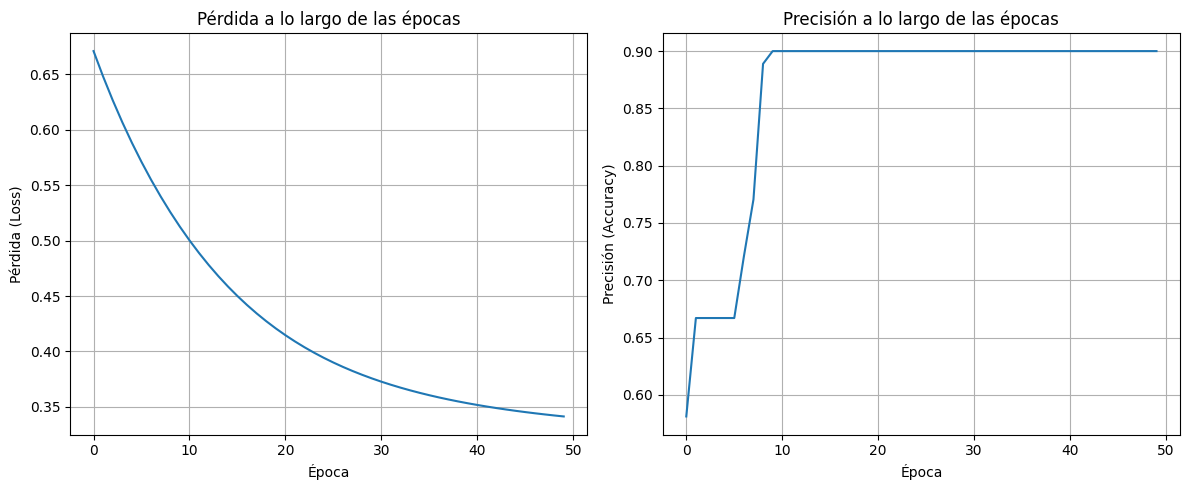

In [9]:
plt.figure(figsize=(12, 5))

# Grafico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(loss_list)
plt.title('Pérdida a lo largo de las épocas')
plt.xlabel('Época')
plt.ylabel('Pérdida (Loss)')
plt.grid(True)

# Grafico de la precisión
plt.subplot(1, 2, 2)
plt.plot(accuracy_list)
plt.title('Precisión a lo largo de las épocas')
plt.xlabel('Época')
plt.ylabel('Precisión (Accuracy)')
plt.grid(True)

plt.tight_layout()
plt.show()